<a href="https://colab.research.google.com/github/ITZ-NANO21-MC/ML-ITZ-NANO-ITZ/blob/Version-2/fcc_cat_dog_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [21]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
Batch_size = 128
epochs = 20
IMG_HEIGHT = 224
IMG_WIDTH = 224

--2025-06-17 15:18:01--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M   193MB/s    in 0.3s    

2025-06-17 15:18:02 (193 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [22]:
# 3

# Generadores
train_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Configuración de flujos
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=Batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=Batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,  # Directorio padre
    classes=['test'],  # Subdirectorio con imágenes
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=Batch_size,
    class_mode=None,  # Para predicción
    shuffle=False
)

# Verificación
print(f"Imágenes de entrenamiento: {train_data_gen.samples}")
print(f"Imágenes de validación: {val_data_gen.samples}")
print(f"Imágenes de prueba: {test_data_gen.samples}")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
Imágenes de entrenamiento: 2000
Imágenes de validación: 1000
Imágenes de prueba: 50


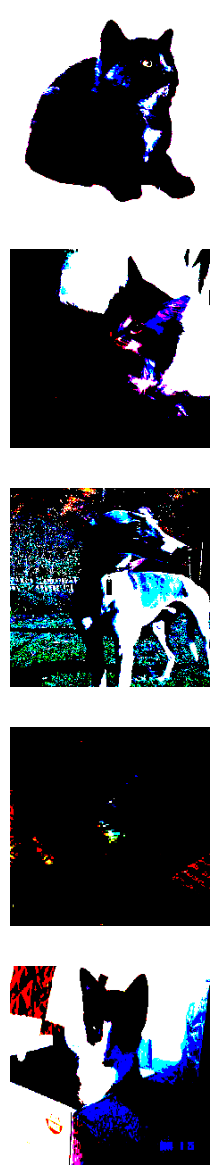

In [23]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [24]:
# 5
train_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

Found 2000 images belonging to 2 classes.


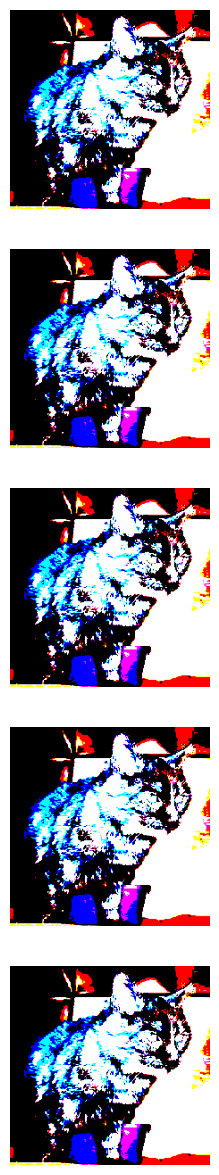

In [25]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=Batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [26]:
# 7

# Cargar VGG16 preentrenado (sin la capa final)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Congelar capas

# Añadir capas personalizadas
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce dimensiones manteniendo información relevante
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Salida binaria (gato/perro)
])

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
# 8
# Implementar Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenar el modelo
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // Batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // Batch_size,
    callbacks=[early_stop]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4979 - loss: 3.3320 - val_accuracy: 0.7902 - val_loss: 0.5940
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.6641 - loss: 1.6445 - val_accuracy: 0.8058 - val_loss: 0.5305
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7323 - loss: 1.2700 - val_accuracy: 0.9163 - val_loss: 0.2081
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.7500 - loss: 1.3415 - val_accuracy: 0.9252 - val_loss: 0.1901
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 868ms/step - accuracy: 0.8202 - loss: 0.7172 - val_accuracy: 0.9554 - val_loss: 0.1189
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.8906 - loss: 0.6298 - val_accuracy: 0.9576 - val_loss: 0.1166
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8924 - loss: 0.4890 - val_accuracy: 0.9654 - val_loss: 0.0912
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.9141 - loss: 0.3193 - val_accuracy: 0.9654 

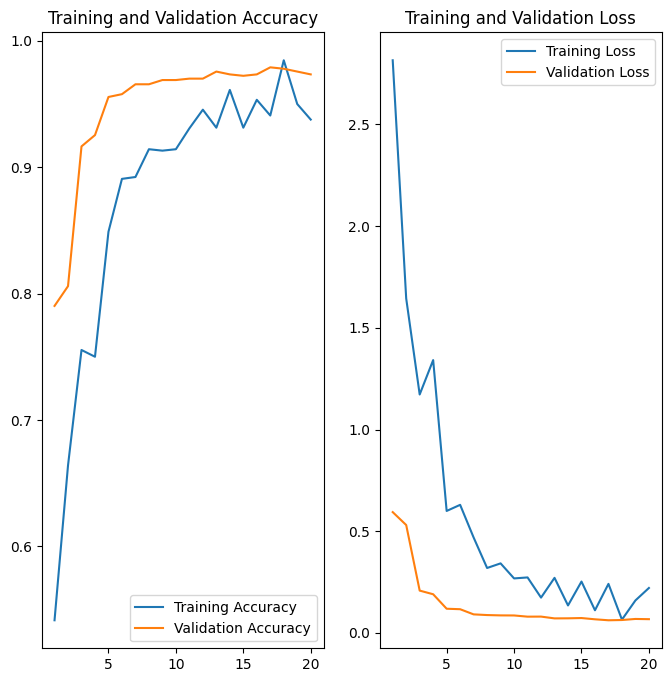

In [28]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# 11

# Verificar imágenes de prueba
print(f"Número de imágenes de prueba encontradas: {test_data_gen.samples}")

if test_data_gen.samples > 0:
    test_data_gen.reset()  # Reiniciar el generador
    probabilities = model.predict(
        test_data_gen,
        steps=(test_data_gen.samples // Batch_size) + 1
    ).flatten()[:50]  # Tomar solo las primeras 50 predicciones

    # Calcular precisión (igual a tu código original)
    answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
    correct = sum(round(prob) == ans for prob, ans in zip(probabilities, answers))
    percentage = (correct / len(answers)) * 100
    passed = percentage >= 63

    print(f"Precisión: {round(percentage, 2)}%")
    if passed:
        print("¡Pasaste el desafío!")
    else:
        print("Tu modelo debe alcanzar al menos 63% de precisión.")
else:
    print("Error: No se encontraron imágenes de prueba.")

Número de imágenes de prueba encontradas: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
Precisión: 96.0%
¡Pasaste el desafío!
